In [2]:
import pandas as pd 
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import matplotlib.pyplot as plt

In [3]:
excel_data = pd.ExcelFile('original_data.xlsx')
# Seach for the sheets in the excel file
print(excel_data.sheet_names)

['Q1. Restaurant Data', 'Q1 Summary', 'Q2 Summary', 'Q3']


# Question 1

In [3]:
# Load the data from the specified sheets
restaurant_data_df = excel_data.parse('Q1. Restaurant Data')
q1_summary_df = excel_data.parse('Q1 Summary')

# Display the first few rows of each dataframe to understand their structure
restaurant_data_df_head = restaurant_data_df.head()
q1_summary_df_head = q1_summary_df.head()

restaurant_data_df_head

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,số cá nhập mỗi ngày,số cá bán được,điều chỉnh stock cho ngày tiếp theo,Có đủ cá bán hay không
1,Day,Stock Units,Sold Units,Stock Change,Missed Demand
2,1,100,100,5,Yes
3,2,105,105,4,Yes
4,3,109,109,3,Yes


In [4]:
restaurant_data_df

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,số cá nhập mỗi ngày,số cá bán được,điều chỉnh stock cho ngày tiếp theo,Có đủ cá bán hay không
1,Day,Stock Units,Sold Units,Stock Change,Missed Demand
2,1,100,100,5,Yes
3,2,105,105,4,Yes
4,3,109,109,3,Yes
...,...,...,...,...,...
3647,3646,114,114,5,Yes
3648,3647,119,116,-5,No
3649,3648,114,97,-4,No
3650,3649,110,83,-4,No


In [5]:
# Drop the first row
restaurant_data_df_cleaned = restaurant_data_df.drop(index=0)

# Set the column titles to the values in the second row (index 1)
restaurant_data_df_cleaned.columns = restaurant_data_df.iloc[1]

# Drop the second row as it is now the header
restaurant_data_df_cleaned = restaurant_data_df_cleaned.drop(index=1)

# Reset the index
restaurant_data_df_cleaned = restaurant_data_df_cleaned.reset_index(drop=True)

restaurant_data_df_cleaned.columns=["Day", "Stock Units", "Sold Units", "Stock Change", "Missed Demand"]

restaurant_data = restaurant_data_df_cleaned.copy()

In [6]:
restaurant_data.dtypes
restaurant_data = restaurant_data.astype({
    'Stock Units': 'int64',
    'Sold Units': 'int64',
    'Stock Change': 'int64',
    'Missed Demand': 'object'
})

restaurant_data.dtypes

Day              object
Stock Units       int64
Sold Units        int64
Stock Change      int64
Missed Demand    object
dtype: object

In [7]:
restaurant_data

,Day,Stock Units,Sold Units,Stock Change,Missed Demand
0,1,100,100,5,Yes
1,2,105,105,4,Yes
2,3,109,109,3,Yes
3,4,112,85,-5,No
4,5,107,107,3,Yes
...,...,...,...,...,...
3645,3646,114,114,5,Yes
3646,3647,119,116,-5,No
3647,3648,114,97,-4,No
3648,3649,110,83,-4,No


## Question 1.1
Estimate the average daily demand of the restaurant

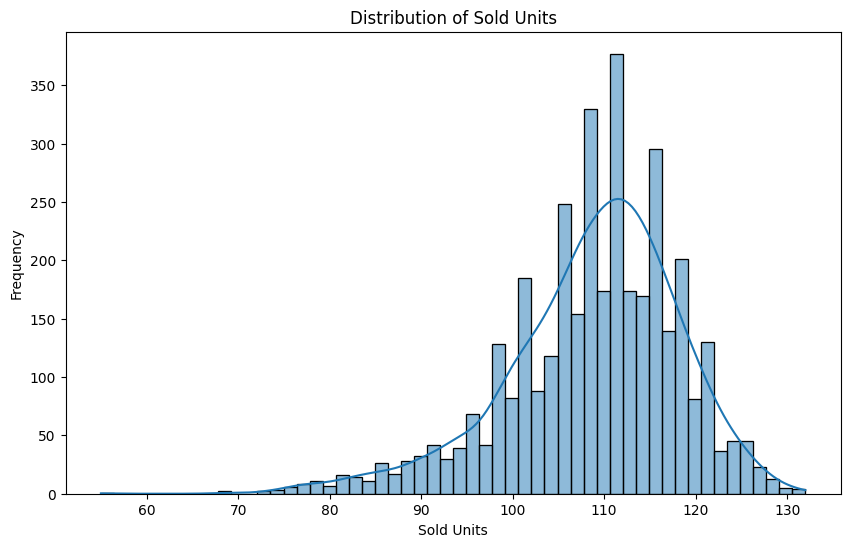

In [8]:
import seaborn as sns

# Convert 'Sold Units' to numeric
restaurant_data['Sold Units'] = pd.to_numeric(restaurant_data['Sold Units'])

# Plot the histogram with KDE
plt.figure(figsize=(10, 6))
sns.histplot(restaurant_data['Sold Units'], kde=True)
plt.title('Distribution of Sold Units')
plt.xlabel('Sold Units')
plt.ylabel('Frequency')
plt.show()

In [9]:
# The distribution kind of looks like a normal distribution, but it is not perfectly normal. However, we can still use the mean to calculate the average demands of customers.
average_demand = restaurant_data['Sold Units'].mean()
average_demand_ceil = np.ceil(average_demand)
print('Average demand of customers (rounded to ceil):', average_demand_ceil)

Average demand of customers (rounded to ceil): 109.0


## Question 1.2
Is the restaurant’s method of adjusting stock reasonable?

In [10]:
# First we need to check to see if missed demand meet expectations or not?
# Calculate the missed demand percentage
missed_demand_percentage = (restaurant_data['Missed Demand'] == 'Yes').mean() * 100
print('Missed Demand Percentage:', missed_demand_percentage)

Missed Demand Percentage: 50.0


The way we the store calculate this missed demand is not good, only 50% of the time that the company is truly able to predict the right customer stock. However the metrics to see whether it is effective or not is actually based on the profit that the restaurant will receive.

In [11]:
restaurant_data["Profit"] = np.where(
    restaurant_data["Sold Units"] <= restaurant_data["Stock Units"],
    restaurant_data["Sold Units"] * 3 - restaurant_data["Stock Units"] * 1,
    restaurant_data["Stock Units"] * 3 - restaurant_data["Stock Units"] * 1
)
restaurant_data

,Day,Stock Units,Sold Units,Stock Change,Missed Demand,Profit
0,1,100,100,5,Yes,200
1,2,105,105,4,Yes,210
2,3,109,109,3,Yes,218
3,4,112,85,-5,No,143
4,5,107,107,3,Yes,214
...,...,...,...,...,...,...
3645,3646,114,114,5,Yes,228
3646,3647,119,116,-5,No,229
3647,3648,114,97,-4,No,177
3648,3649,110,83,-4,No,139


In [12]:
total_profit_restaurant_data = restaurant_data['Profit'].sum()
print('Total Profit of restaurant_data:', total_profit_restaurant_data)

Total Profit of restaurant_data: 769702


In [13]:
# Convert 'day' to actual dates starting from January 1st, 2010
start_date = pd.to_datetime('2010-01-01')
restaurant_data['Date'] = start_date + pd.to_timedelta(restaurant_data['Day'] - 1, unit='D')
restaurant_data.drop(columns='Day', inplace=True)
restaurant_data.set_index('Date', inplace=True)
restaurant_data


,Stock Units,Sold Units,Stock Change,Missed Demand,Profit
Date,,,,,
2010-01-01,100,100,5,Yes,200
2010-01-02,105,105,4,Yes,210
2010-01-03,109,109,3,Yes,218
2010-01-04,112,85,-5,No,143
2010-01-05,107,107,3,Yes,214
...,...,...,...,...,...
2019-12-25,114,114,5,Yes,228
2019-12-26,119,116,-5,No,229
2019-12-27,114,97,-4,No,177


In [15]:
# 
df = restaurant_data.copy()
df.drop(columns='Profit', inplace=True)
# Parameters
safety_stock_percentage = 0.95  # 10% of sold units as safety stock
stock_units_initial = df['Stock Units'][0]  # Start with initial stock
profit_per_unit = 2  # Assume $2 profit per fish sold

# Adding a column for adjusted stock units after each day's adjustment
df['Adjusted Stock'] = df['Stock Units'].copy()

# Loop over each day and adjust stock based on the previous day's data
for i in range(1, len(df)):
    # Calculate safety stock
    safety_stock = df['Sold Units'][i-1] * safety_stock_percentage
    
    # Adjust stock for the current day based on previous day's sold units and safety stock
    df.at[df.index[i], 'Adjusted Stock'] = df['Stock Units'][i-1] + safety_stock
    
    # Assuming stock change for the day is already accounted for, so adjust for next day accordingly
df['Profit'] = np.where(
    df['Sold Units'] <= df['Adjusted Stock'],
    df['Sold Units'] * 3 - df['Adjusted Stock'] * 1,
    df['Adjusted Stock'] * 3 - df['Adjusted Stock'] * 1
)
total_profit = df['Profit'].sum()
print('Total Profit:', total_profit)

missed_demand_proportion = (df['Missed Demand'] == 'Yes').mean() * 100
print('Proportion of Missed Demand = Yes:', missed_demand_proportion)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\236689723.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stock_units_initial = df['Stock Units'][0]  # Start with initial stock
C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\236689723.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  safety_stock = df['Sold Units'][i-1] * safety_stock_percentage
C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\236689723.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

Total Profit: 392629.25
Proportion of Missed Demand = Yes: 50.0


In [25]:
# 
df = restaurant_data.copy()
df.drop(columns='Profit', inplace=True)
# Parameters
alpha = 0.12  # Correction factor, adjust this between 0 and 1
stock_units_initial = df['Stock Units'][0]  # Start with initial stock
df['Adjusted Stock'] = 0

# Start with the initial stock
df.at[df.index[0], 'Adjusted Stock'] = stock_units_initial

# Loop through each day and adjust stock based on error correction
for i in range(1, len(df)):
    # Calculate error: Difference between sold units and previous stock units
    error = df['Sold Units'][i-1] - df['Stock Units'][i-1]
    
    # Apply error correction to adjust stock for the current day
    adjusted_stock = df['Stock Units'][i-1] + alpha * error
    
    # Update stock for current day
    df.at[df.index[i], 'Adjusted Stock'] = adjusted_stock
df['Profit'] = np.where(
    df['Sold Units'] <= df['Adjusted Stock'],
    df['Sold Units'] * 3 - df['Adjusted Stock'] * 1,
    df['Adjusted Stock'] * 3 - df['Adjusted Stock'] * 1
)
total_profit = df['Profit'].sum()
print('Total Profit:', total_profit)

missed_demand_proportion = (df['Missed Demand'] == 'Yes').mean() * 100
print('Proportion of Missed Demand = Yes:', missed_demand_proportion)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_11516\796381277.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stock_units_initial = df['Stock Units'][0]  # Start with initial stock
C:\Users\lenovo\AppData\Local\Temp\ipykernel_11516\796381277.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  error = df['Sold Units'][i-1] - df['Stock Units'][i-1]
C:\Users\lenovo\AppData\Local\Temp\ipykernel_11516\796381277.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by p

Total Profit: 761925.76
Proportion of Missed Demand = Yes: 50.0


In [21]:
# Assuming restaurant_data is similar to the previous dataset, copying and processing
df = restaurant_data.copy()  # using the combined data as restaurant_data equivalent
df.drop(columns='Profit', inplace=True)  # Removing Profit for now

# Re-initialize the 'Next Day Stock' to the same as 'Stock Units' for now
df['Next Day Stock'] = df['Stock Units'].copy()

# Initialize control rate
control_rate = 0.5  # Start with a slightly lower rate than 0.95

# Loop through each day, calculate standard deviation, and adjust stock units for the next day
for i in range(1, len(df)):
    # Calculate the standard deviation of the previous and current sold units
    if i > 1:
        std_dev = df['Sold Units'][:i].std()
    else:
        std_dev = abs(df['Sold Units'][i] - df['Sold Units'][i-1])  # for the first loop, fallback to absolute difference

    # If the standard deviation is 0, use a minimum adjustment
    if std_dev == 0:
        std_dev = 1
    
    # Sampling a random number between 1 and the standard deviation
    adjustment = np.random.randint(1, int(std_dev) + 1)
    
    # Logic to adjust stock for the next day
    if df['Stock Units'][i-1] <= df['Sold Units'][i-1]:
        # Increase stock if the previous day's stock was less than or equal to sold units
        df.at[df.index[i], 'Next Day Stock'] = np.ceil(df['Stock Units'][i-1] + control_rate * adjustment).astype(int)
    else:
        # Decrease stock if the previous day's stock was greater than sold units
        df.at[df.index[i], 'Next Day Stock'] = np.ceil(df['Stock Units'][i-1] - control_rate * adjustment).astype(int)

    # Set the stock change as the difference between Next Day Stock and previous Stock Units
    df.at[df.index[i], 'Stock Change'] = df['Next Day Stock'][i] - df['Stock Units'][i-1]
    
    # Adjust the control rate dynamically based on missed demand
    if df['Next Day Stock'][i] >= df['Sold Units'][i]:
        # Increase control rate slightly to increase stock if demand was missed
        control_rate = min(control_rate + 0.05, 0.95)  # Cap the control rate at 0.95
    else:
        # Decrease control rate to reduce stock adjustments
        control_rate = max(control_rate - 0.05, 0.7)  # Ensure control rate doesn't drop too low

# Calculate the profit using next day stock and sold units
df['Profit'] = np.where(
    df['Sold Units'] <= df['Next Day Stock'],
    df['Sold Units'] * 3 - df['Next Day Stock'] * 1,
    df['Next Day Stock'] * 3 - df['Next Day Stock'] * 1
)

# Calculate the total profit
total_profit = df['Profit'].sum()
print('Total Profit:', total_profit)

# Drop the original Stock Units and Missed Demand columns
df.drop(columns=['Stock Units', 'Missed Demand'], inplace=True)

# Create a new Missed Demand column
df['Missed Demand'] = np.where(df['Next Day Stock'] >= df['Sold Units'], 'Yes', 'No')

# Calculate the proportion of "Yes" in the new Missed Demand column
missed_demand_proportion = (df['Missed Demand'] == 'Yes').mean() * 100
print('Proportion of Missed Demand = Yes:', missed_demand_proportion)




C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\3922560669.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_dev = abs(df['Sold Units'][i] - df['Sold Units'][i-1])  # for the first loop, fallback to absolute difference
C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\3922560669.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['Stock Units'][i-1] <= df['Sold Units'][i-1]:
C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\3922560669.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with

Total Profit: 762783
Proportion of Missed Demand = Yes: 78.6027397260274


In [29]:
# Assuming restaurant_data is similar to the previous dataset, copying and processing
df = restaurant_data.copy()  # using the combined data as restaurant_data equivalent
df.drop(columns='Profit', inplace=True)  # Removing Profit for now

# Re-initialize the 'Next Day Stock' to the same as 'Stock Units' for now
df['Next Day Stock'] = df['Stock Units'].copy()

# Define control rate
control_rate = 0.2  # Initial control rate

# Initialize list to store absolute differences for sampling
abs_diff_history = []

# Loop through each day, calculate dynamic sampling, and adjust stock units for the next day
for i in range(1, len(df)):
    # Calculate the absolute difference between the current and previous day's sold units
    abs_diff = abs(df['Sold Units'][i] - df['Sold Units'][i-1])
    abs_diff_history.append(abs_diff)  # Append the difference to our history

    # After we have at least 2 days of data, start calculating mean and std deviation of the differences
    if len(abs_diff_history) > 1:
        diff_mean = np.mean(abs_diff_history)
        diff_std = np.std(abs_diff_history)
    else:
        diff_mean = abs_diff
        diff_std = 1  # Default to 1 if we have no history yet

    # Sample a random number from a normal distribution based on the mean and std of the differences
    adjustment = np.random.normal(loc=diff_mean, scale=diff_std)

    # Ensure adjustment is positive and at least 1
    adjustment = max(1, abs(int(adjustment)))
    
    # Logic to adjust stock for the next day
    if df['Stock Units'][i-1] <= df['Sold Units'][i-1]:
        # Increase stock if the previous day's stock was less than or equal to sold units
        df.at[df.index[i], 'Next Day Stock'] = np.ceil(df['Stock Units'][i-1] + control_rate * adjustment).astype(int)
    else:
        # Decrease stock if the previous day's stock was greater than sold units
        df.at[df.index[i], 'Next Day Stock'] = np.ceil(df['Stock Units'][i-1] - control_rate * adjustment).astype(int)

    # Set the stock change as the difference between Next Day Stock and previous Stock Units
    df.at[df.index[i], 'Stock Change'] = df['Next Day Stock'][i] - df['Stock Units'][i-1]

# Calculate the profit using next day stock and sold units
df['Profit'] = np.where(
    df['Sold Units'] <= df['Next Day Stock'],
    df['Sold Units'] * 3 - df['Next Day Stock'] * 1,
    df['Next Day Stock'] * 3 - df['Next Day Stock'] * 1
)

# Calculate the total profit
total_profit = df['Profit'].sum()
print('Total Profit:', total_profit)

# Drop the original Stock Units and Missed Demand columns
df.drop(columns=['Stock Units', 'Missed Demand'], inplace=True)

# Create a new Missed Demand column
df['Missed Demand'] = np.where(df['Next Day Stock'] >= df['Sold Units'], 'Yes', 'No')

# Calculate the proportion of "Yes" in the new Missed Demand column
missed_demand_proportion = (df['Missed Demand'] == 'Yes').mean() * 100
print('Proportion of Missed Demand = Yes:', missed_demand_proportion)




C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\267759306.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abs_diff = abs(df['Sold Units'][i] - df['Sold Units'][i-1])
C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\267759306.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['Stock Units'][i-1] <= df['Sold Units'][i-1]:
C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\267759306.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use 

Total Profit: 763467
Proportion of Missed Demand = Yes: 80.6027397260274


In [31]:
# Assuming restaurant_data is similar to the previous dataset, copying and processing
df = restaurant_data.copy()  # using the combined data as restaurant_data equivalent
df.drop(columns='Profit', inplace=True)  # Removing Profit for now

# Re-initialize the 'Next Day Stock' to the same as 'Stock Units' for now
df['Next Day Stock'] = df['Stock Units'].copy()

# Define control rate and baseline profit
control_rate = 0.4  # Initial control rate
baseline_profit = 200  # Example baseline profit (can be dynamic)

# Loop through each day, adjust stock units based on profit performance
for i in range(1, len(df)):
    # Calculate today's profit (based on previous day's stock and sales)
    if df['Sold Units'][i-1] <= df['Stock Units'][i-1]:
        profit = df['Sold Units'][i-1] * 3 - df['Stock Units'][i-1] * 1
    else:
        profit = df['Stock Units'][i-1] * 3 - df['Stock Units'][i-1] * 1
    
    # Adjust stock based on profit deviation from the baseline
    profit_deviation = profit - baseline_profit
    
    # If profit is low (below baseline), increase stock more
    if profit_deviation < 0:
        adjustment = np.random.randint(2, 5) * control_rate * (1 - profit_deviation / baseline_profit)
        df.at[df.index[i], 'Next Day Stock'] = np.ceil(df['Stock Units'][i-1] + adjustment).astype(int)
    
    # If profit is high (above baseline), decrease stock
    else:
        adjustment = np.random.randint(2, 5) * control_rate * (1 + profit_deviation / baseline_profit)
        df.at[df.index[i], 'Next Day Stock'] = np.ceil(df['Stock Units'][i-1] - adjustment).astype(int)
    
    # Set the stock change as the difference between Next Day Stock and previous Stock Units
    df.at[df.index[i], 'Stock Change'] = df['Next Day Stock'][i] - df['Stock Units'][i-1]

# Calculate the profit using next day stock and sold units
df['Profit'] = np.where(
    df['Sold Units'] <= df['Next Day Stock'],
    df['Sold Units'] * 3 - df['Next Day Stock'] * 1,
    df['Next Day Stock'] * 3 - df['Next Day Stock'] * 1
)

# Calculate the total profit
total_profit = df['Profit'].sum()
print('Total Profit:', total_profit)

# Drop the original Stock Units and Missed Demand columns
df.drop(columns=['Stock Units', 'Missed Demand'], inplace=True)

# Create a new Missed Demand column
df['Missed Demand'] = np.where(df['Next Day Stock'] >= df['Sold Units'], 'Yes', 'No')

# Calculate the proportion of "Yes" in the new Missed Demand column
missed_demand_proportion = (df['Missed Demand'] == 'Yes').mean() * 100
print('Proportion of Missed Demand = Yes:', missed_demand_proportion)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\4280201012.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['Sold Units'][i-1] <= df['Stock Units'][i-1]:
C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\4280201012.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  profit = df['Sold Units'][i-1] * 3 - df['Stock Units'][i-1] * 1
C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\4280201012.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positio

Total Profit: 757411
Proportion of Missed Demand = Yes: 73.15068493150685


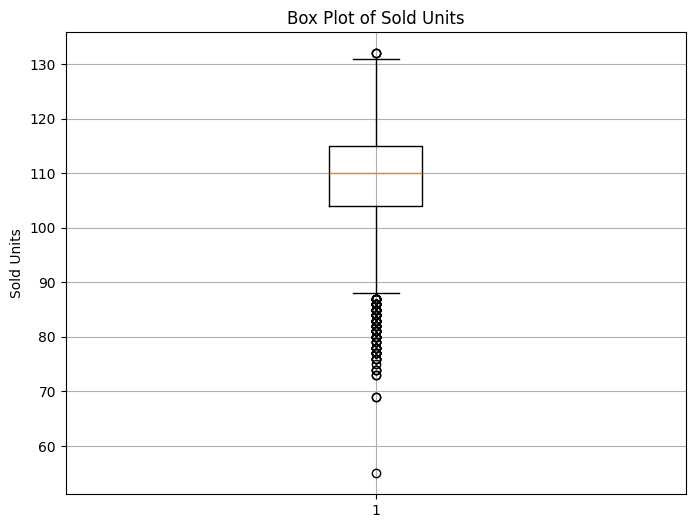

In [32]:
import matplotlib.pyplot as plt

# Draw a box plot for the 'Sold Units' column
plt.figure(figsize=(8, 6))
plt.boxplot(restaurant_data['Sold Units'])
plt.title('Box Plot of Sold Units')
plt.ylabel('Sold Units')
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
df = restaurant_data.copy()
df.drop(columns='Profit', inplace=True)
# Initialize 'Next Day Stock'
df['Next Day Stock'] = df['Sold Units'].copy()

# Function to calculate upper whisker based on the IQR method
def calculate_whisker(q1, q3):
    iqr = q3 - q1
    return q3 + 1.5 * iqr  # Standard whisker calculation (1.5 * IQR)

# Loop through each day, calculate box plot stats and adjust stock accordingly
for i in range(1, len(df)):
    # Dynamically calculate the box plot statistics up to the current day
    q1 = df['Sold Units'][:i].quantile(0.25)  # Q1 (25th percentile)
    median = df['Sold Units'][:i].median()  # Median (50th percentile)
    q3 = df['Sold Units'][:i].quantile(0.75)  # Q3 (75th percentile)
    upper_whisker = calculate_whisker(q1, q3)  # Upper whisker

    # Adjust stock based on median and upper whisker values
    base_stock = median
    safety_stock = (upper_whisker - q3)  # Use the difference between upper whisker and Q3 as buffer
    total_stock = np.ceil(base_stock + safety_stock).astype(int)  # Total stock for next day
    
    # Update 'Next Day Stock' based on the calculated total stock
    df.at[df.index[i], 'Next Day Stock'] = total_stock
    
df['Profit'] = np.where(
    df['Sold Units'] <= df['Next Day Stock'],
    df['Sold Units'] * 3 - df['Next Day Stock'] * 1,
    df['Next Day Stock'] * 3 - df['Next Day Stock'] * 1
)

# Calculate the total profit
total_profit = df['Profit'].sum()
print('Total Profit:', total_profit)

# Drop the original Stock Units and Missed Demand columns
df.drop(columns=['Stock Units', 'Missed Demand'], inplace=True)

# Create a new Missed Demand column
df['Missed Demand'] = np.where(df['Next Day Stock'] >= df['Sold Units'], 'Yes', 'No')

# Calculate the proportion of "Yes" in the new Missed Demand column
missed_demand_proportion = (df['Missed Demand'] == 'Yes').mean() * 100
print('Proportion of Missed Demand = Yes:', missed_demand_proportion)


Total Profit: 754467
Proportion of Missed Demand = Yes: 86.65753424657534


In [43]:
# Add 'Month' column for easier grouping
df = restaurant_data.copy()
df.drop(columns='Profit', inplace=True)
df['Month'] = df.index.month

# Initialize 'Next Day Stock' and control rate
df['Next Day Stock'] = df['Sold Units'].copy()
control_rate = 0.8

# Loop through each day, adjust fish being added dynamically based on monthly fluctuation
for i in range(1, len(df)):
    current_month = df['Month'][i]
    
    # Calculate the standard deviation of sold units for the current month
    monthly_std_dev = df[df['Month'] == current_month]['Sold Units'].std()
    
    # Dynamically adjust the range of fish added based on standard deviation
    if monthly_std_dev > 10:  # Arbitrary threshold to indicate large fluctuations
        fish_add_range = (3, 7)  # Larger range for more fluctuation
    else:
        fish_add_range = (2, 5)  # Smaller range for less fluctuation
    
    # Sampling a random number from the adjusted fish add range
    adjustment = np.random.randint(fish_add_range[0], fish_add_range[1] + 1)
    
    # Logic to adjust stock for the next day based on sold units
    if df['Sold Units'][i-1] <= df['Sold Units'][i-1]:
        df.at[df.index[i], 'Next Day Stock'] = np.ceil(df['Sold Units'][i-1] + control_rate * adjustment).astype(int)
    else:
        df.at[df.index[i], 'Next Day Stock'] = np.ceil(df['Sold Units'][i-1] - control_rate * adjustment).astype(int)
    
    # Set the stock change as the difference between Next Day Stock and previous Sold Units
    df.at[df.index[i], 'Stock Change'] = df['Next Day Stock'][i] - df['Sold Units'][i-1]

df['Profit'] = np.where(
    df['Sold Units'] <= df['Next Day Stock'],
    df['Sold Units'] * 3 - df['Next Day Stock'] * 1,
    df['Next Day Stock'] * 3 - df['Next Day Stock'] * 1
)

# Calculate the total profit
total_profit = df['Profit'].sum()
print('Total Profit:', total_profit)

# Drop the original Stock Units and Missed Demand columns
df.drop(columns=['Stock Units', 'Missed Demand'], inplace=True)

# Create a new Missed Demand column
df['Missed Demand'] = np.where(df['Next Day Stock'] >= df['Sold Units'], 'Yes', 'No')

# Calculate the proportion of "Yes" in the new Missed Demand column
missed_demand_proportion = (df['Missed Demand'] == 'Yes').mean() * 100
print('Proportion of Missed Demand = Yes:', missed_demand_proportion)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\358173129.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_month = df['Month'][i]
C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\358173129.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['Sold Units'][i-1] <= df['Sold Units'][i-1]:
C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\358173129.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.at[df.ind

Total Profit: 752777
Proportion of Missed Demand = Yes: 64.46575342465754


In [52]:
# Constants for EOQ formula
# Add 'Month' column for easier grouping
df = restaurant_data.copy()
df.drop(columns='Profit', inplace=True)
# Initialize 'Next Day Stock'
df['Next Day Stock'] = df['Sold Units'].copy()

# Loop through each day, calculate mean and standard deviation, and adjust stock for the next day
for i in range(1, len(df)):
    # Calculate mean and standard deviation of Sold Units up to the current day
    mean_sold = df['Sold Units'][:i].mean()
    std_sold = df['Sold Units'][:i].std()
    
    # Logic to adjust stock for the next day
    if df['Sold Units'][i-1] < mean_sold:
        # Increase stock by Sold Units + std deviation if today's sold units are below mean
        df.at[df.index[i], 'Next Day Stock'] = np.ceil(df['Sold Units'][i-1] + 0.95*std_sold).astype(int)
    else:
        # If Sold Units are above or equal to mean, keep stock same as Sold Units or make small adjustment
        df.at[df.index[i], 'Next Day Stock'] = df['Sold Units'][i-1]
    
    # Set the stock change as the difference between Next Day Stock and Sold Units of today
    df.at[df.index[i], 'Stock Change'] = df['Next Day Stock'][i] - df['Sold Units'][i-1]

    
df['Profit'] = np.where(
    df['Sold Units'] <= df['Next Day Stock'],
    df['Sold Units'] * 3 - df['Next Day Stock'] * 1,
    df['Next Day Stock'] * 3 - df['Next Day Stock'] * 1
)

# Calculate the total profit
total_profit = df['Profit'].sum()
print('Total Profit:', total_profit)

# Drop the original Stock Units and Missed Demand columns
df.drop(columns=['Stock Units', 'Missed Demand'], inplace=True)

# Create a new Missed Demand column
df['Missed Demand'] = np.where(df['Next Day Stock'] >= df['Sold Units'], 'Yes', 'No')

# Calculate the proportion of "Yes" in the new Missed Demand column
missed_demand_proportion = (df['Missed Demand'] == 'Yes').mean() * 100
print('Proportion of Missed Demand = Yes:', missed_demand_proportion)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\4022095914.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['Sold Units'][i-1] < mean_sold:
C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\4022095914.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.at[df.index[i], 'Next Day Stock'] = df['Sold Units'][i-1]
C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\4022095914.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Total Profit: 754956
Proportion of Missed Demand = Yes: 63.83561643835617


In [54]:
# Initialize 'Stock Units' and 'Next Day Stock'
df = restaurant_data.copy()
df.drop(columns='Profit', inplace=True)
df['Stock Units'] = df['Sold Units'].copy()  # Initialize with sold units for simplicity
df['Next Day Stock'] = df['Sold Units'].copy()

# Loop through each day, calculate and adjust stock based on the conditions
for i in range(1, len(df)):
    mean_sold = df['Sold Units'][:i].mean()  # Calculate mean Sold Units until today
    
    if df['Sold Units'][i-1] >= df['Stock Units'][i-1]:
        # Case 1: Sold Units >= Stock Units -> keep stock or add random value (1, diff)
        diff = df['Sold Units'][i-1] - df['Stock Units'][i-1]
        if diff > 0:
            random_addition = np.random.randint(1, diff + 1)  # Random addition in range (1, diff)
        else:
            random_addition = 0  # No addition if no diff
        
        # Update stock for the next day
        df.at[df.index[i], 'Next Day Stock'] = df['Stock Units'][i-1] + random_addition
        
    else:
        # Case 2: Sold Units < Stock Units -> Adjust stock to mean Sold Units up to today
        df.at[df.index[i], 'Next Day Stock'] = np.ceil(mean_sold).astype(int)
    
    # Update stock for the next day as new stock units
    df.at[df.index[i], 'Stock Units'] = df['Next Day Stock'][i]
df['Profit'] = np.where(
    df['Sold Units'] <= df['Next Day Stock'],
    df['Sold Units'] * 3 - df['Next Day Stock'] * 1,
    df['Next Day Stock'] * 3 - df['Next Day Stock'] * 1
)

# Calculate the total profit
total_profit = df['Profit'].sum()
print('Total Profit:', total_profit)

# Drop the original Stock Units and Missed Demand columns
df.drop(columns=['Stock Units', 'Missed Demand'], inplace=True)

# Create a new Missed Demand column
df['Missed Demand'] = np.where(df['Next Day Stock'] >= df['Sold Units'], 'Yes', 'No')

# Calculate the proportion of "Yes" in the new Missed Demand column
missed_demand_proportion = (df['Missed Demand'] == 'Yes').mean() * 100
print('Proportion of Missed Demand = Yes:', missed_demand_proportion)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\1611765473.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['Sold Units'][i-1] >= df['Stock Units'][i-1]:
C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\1611765473.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff = df['Sold Units'][i-1] - df['Stock Units'][i-1]
C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\1611765473.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Total Profit: 759911
Proportion of Missed Demand = Yes: 56.02739726027397


In [57]:
# Initialize 'Stock Units' and 'Next Day Stock'
df = restaurant_data.copy()
df.drop(columns='Profit', inplace=True)
df['Stock Units'] = df['Sold Units'].copy()  # Initialize with sold units for simplicity
# Initialize 'Next Day Stock'
df['Next Day Stock'] = df['Sold Units'].copy()

# Define buffer as a percentage of standard deviation (can adjust as needed)
buffer_rate = 1  # 20% of standard deviation

# Loop through each day, calculate mean, std, and adjust stock based on the buffer
for i in range(1, len(df)):
    mean_sold = df['Sold Units'][:i].mean()  # Calculate mean Sold Units until today
    std_sold = df['Sold Units'][:i].std()  # Calculate standard deviation until today
    
    # Calculate buffer (buffer can be based on std deviation, or a fixed value)
    buffer = buffer_rate * std_sold
    
    # Adjust stock to mean Sold Units + buffer for the next day
    df.at[df.index[i], 'Next Day Stock'] = np.ceil(mean_sold + buffer).astype(int)

df['Profit'] = np.where(
    df['Sold Units'] <= df['Next Day Stock'],
    df['Sold Units'] * 3 - df['Next Day Stock'] * 1,
    df['Next Day Stock'] * 3 - df['Next Day Stock'] * 1
)

# Calculate the total profit
total_profit = df['Profit'].sum()
print('Total Profit:', total_profit)

# Drop the original Stock Units and Missed Demand columns
df.drop(columns=['Stock Units', 'Missed Demand'], inplace=True)

# Create a new Missed Demand column
df['Missed Demand'] = np.where(df['Next Day Stock'] >= df['Sold Units'], 'Yes', 'No')

# Calculate the proportion of "Yes" in the new Missed Demand column
missed_demand_proportion = (df['Missed Demand'] == 'Yes').mean() * 100
print('Proportion of Missed Demand = Yes:', missed_demand_proportion)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\2071029938.py:20: RuntimeWarning: invalid value encountered in cast
  df.at[df.index[i], 'Next Day Stock'] = np.ceil(mean_sold + buffer).astype(int)


Total Profit: -4294214995
Proportion of Missed Demand = Yes: 89.34246575342466


In [59]:
# Initialize 'Stock Units' and 'Next Day Stock'
df = restaurant_data.copy()
df.drop(columns='Profit', inplace=True)
# Parameters for profit calculation
P = 3  # Profit per fish sold
H = 1  # Holding cost per fish

# Initialize 'Next Day Stock' and 'Profit'
df['Next Day Stock'] = df['Sold Units'].copy()
df['Profit'] = 0  # Initialize profit column

# Function to calculate daily profit
def calculate_profit(sold_today, stock_today, P, H):
    if sold_today <= stock_today:
        # All demand is satisfied, and stock incurs holding cost
        return (sold_today * P) - (stock_today * H)
    else:
        # Not enough stock to satisfy all demand (lost sales)
        return (stock_today * P) - (stock_today * H)

# Optimization process: Simulate different stock levels and maximize profit
for i in range(1, len(df)):
    # Try different stock levels to find the one that maximizes profit
    best_profit = -np.inf
    best_stock_level = 0
    for stock in range(int(df['Sold Units'][i-1]), int(df['Sold Units'][i-1]) + 20):
        profit = calculate_profit(df['Sold Units'][i-1], stock, P, H)
        if profit > best_profit:
            best_profit = profit
            best_stock_level = stock
    
    # Set the best stock level for the next day
    df.at[df.index[i], 'Next Day Stock'] = best_stock_level
    df.at[df.index[i], 'Profit'] = best_profit

df['Profit'] = np.where(
    df['Sold Units'] <= df['Next Day Stock'],
    df['Sold Units'] * 3 - df['Next Day Stock'] * 1,
    df['Next Day Stock'] * 3 - df['Next Day Stock'] * 1
)

# Calculate the total profit
total_profit = df['Profit'].sum()
print('Total Profit:', total_profit)

# Drop the original Stock Units and Missed Demand columns
df.drop(columns=['Stock Units', 'Missed Demand'], inplace=True)

# Create a new Missed Demand column
df['Missed Demand'] = np.where(df['Next Day Stock'] >= df['Sold Units'], 'Yes', 'No')

# Calculate the proportion of "Yes" in the new Missed Demand column
missed_demand_proportion = (df['Missed Demand'] == 'Yes').mean() * 100
print('Proportion of Missed Demand = Yes:', missed_demand_proportion)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\2119970791.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for stock in range(int(df['Sold Units'][i-1]), int(df['Sold Units'][i-1]) + 20):
C:\Users\lenovo\AppData\Local\Temp\ipykernel_16152\2119970791.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  profit = calculate_profit(df['Sold Units'][i-1], stock, P, H)


Total Profit: 746185
Proportion of Missed Demand = Yes: 43.397260273972606


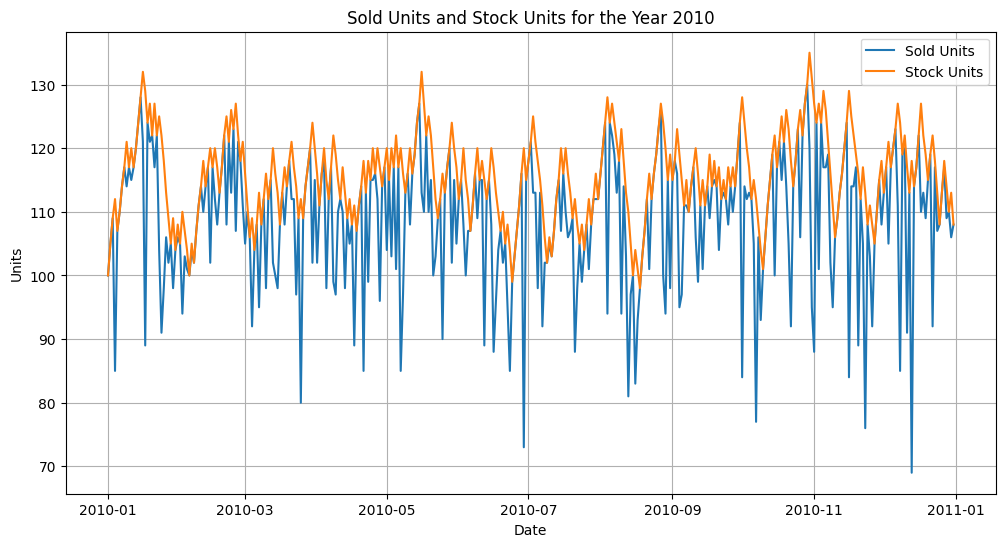

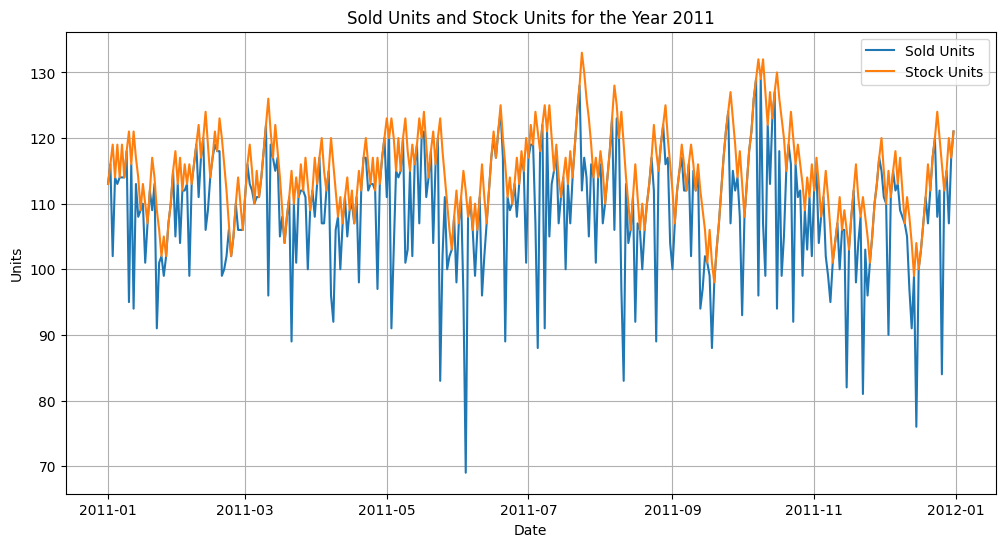

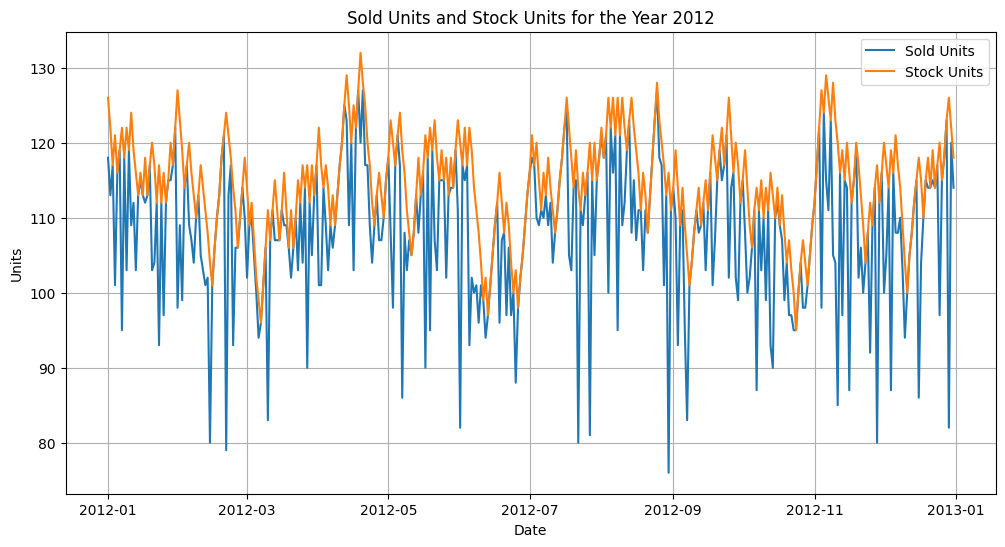

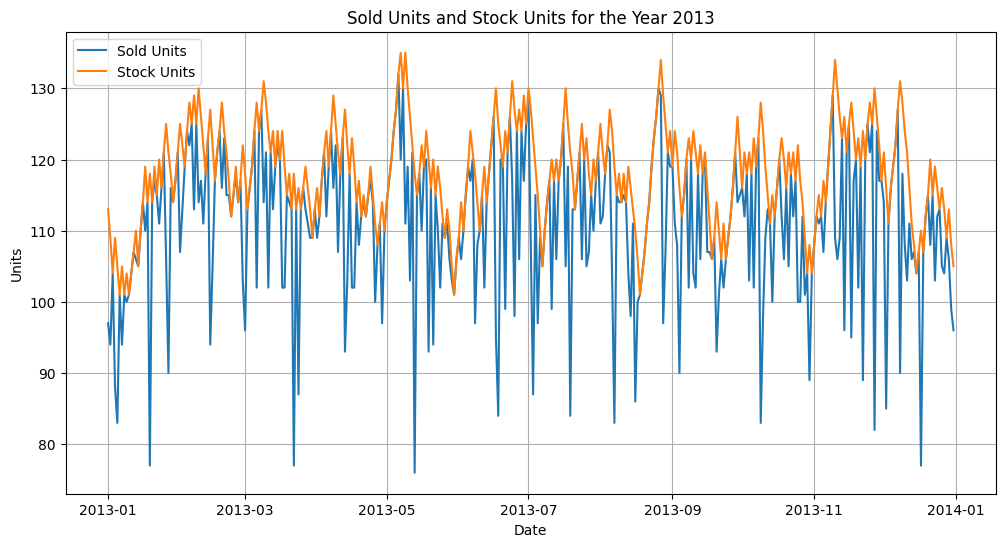

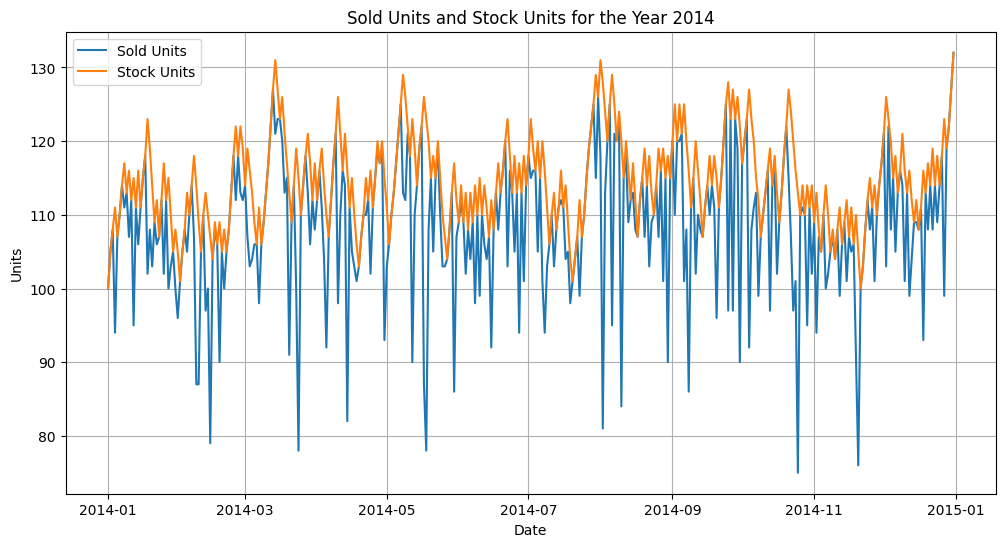

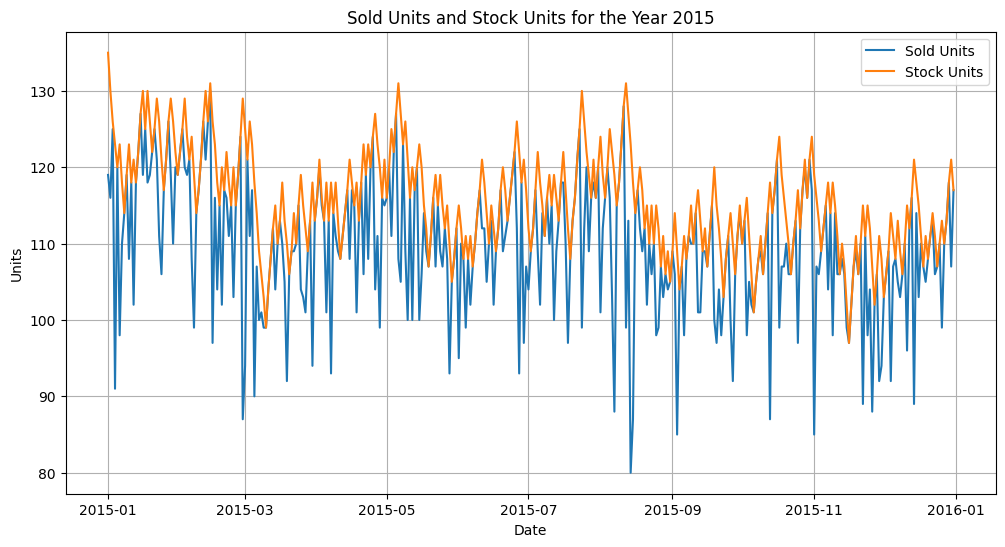

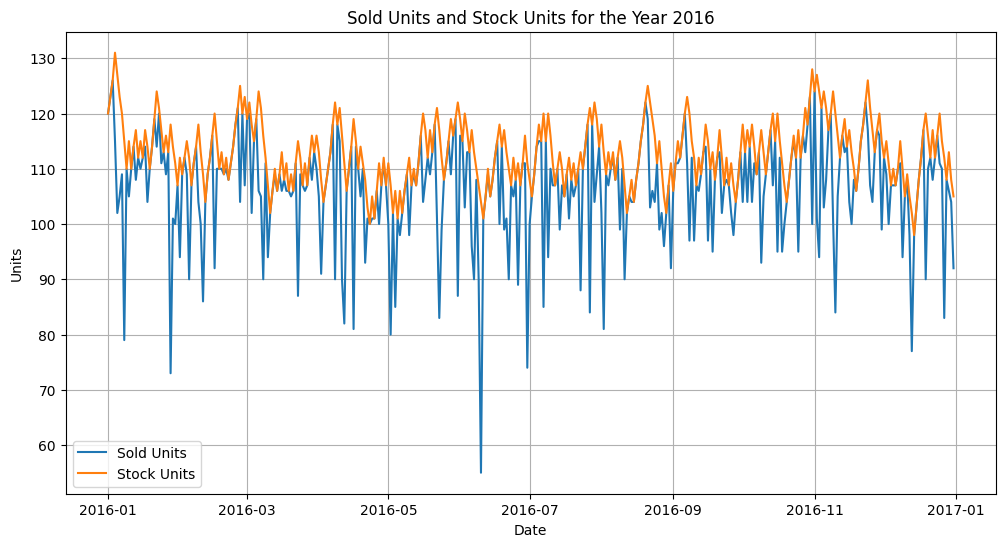

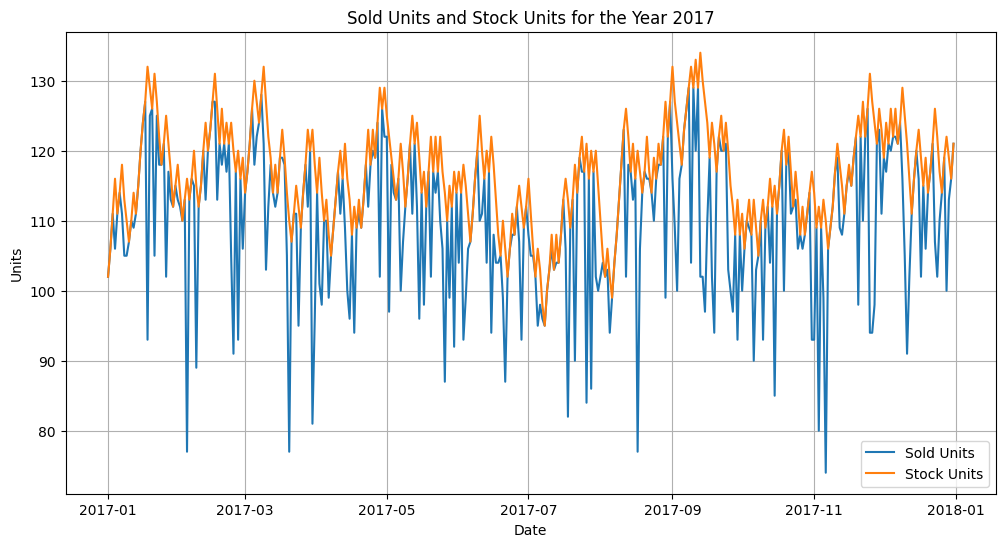

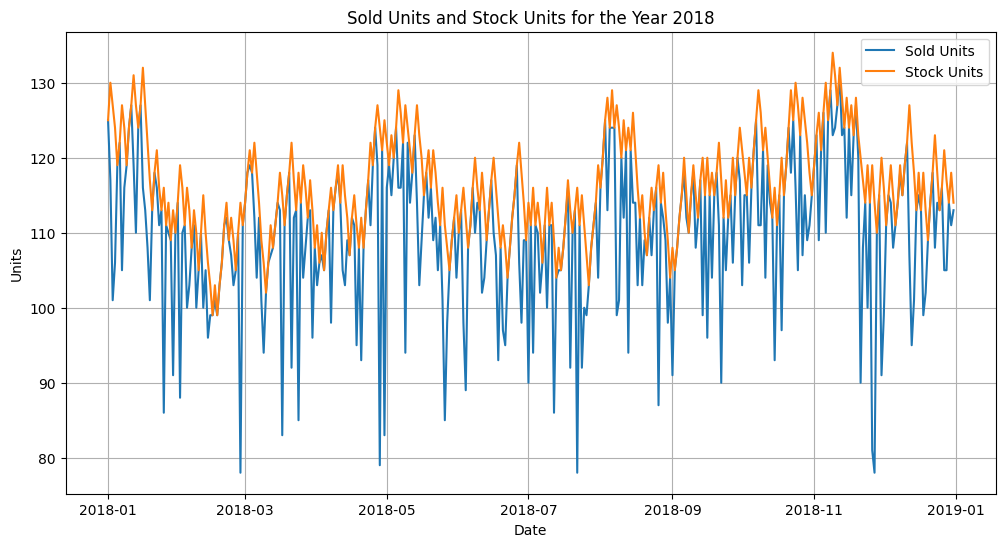

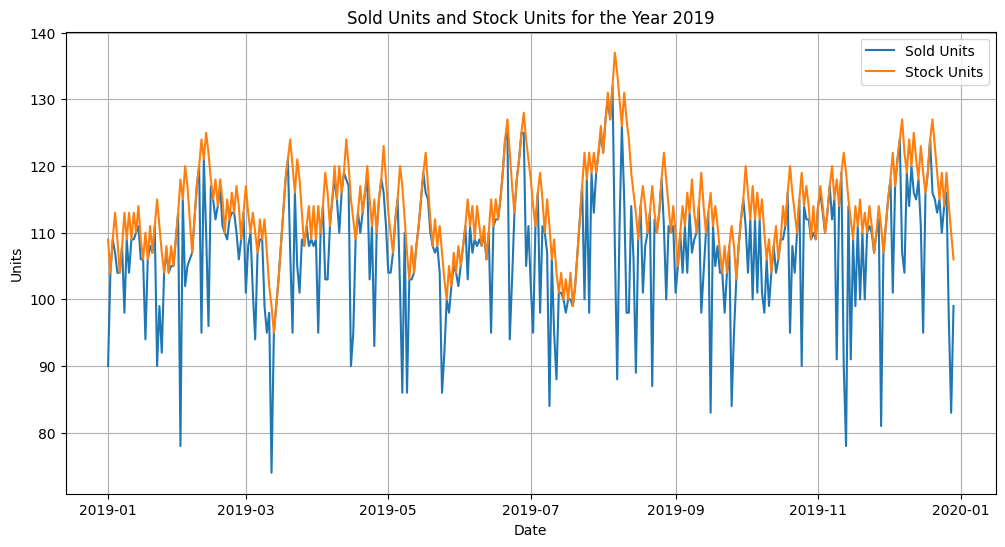

In [16]:
# Get the unique years from the 'Date' column
years = restaurant_data['Date'].dt.year.unique()

# Loop through each year and plot the data
for year in years:
    df_year = restaurant_data[restaurant_data['Date'].dt.year == year]
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_year['Date'], df_year['Sold Units'], label='Sold Units')
    plt.plot(df_year['Date'], df_year['Stock Units'], label='Stock Units')
    plt.xlabel('Date')
    plt.ylabel('Units')
    plt.title(f'Sold Units and Stock Units for the Year {year}')
    plt.legend()
    plt.grid(True)
    plt.show()

We can see that most of the time, the stock units are always higher than the sold units and however can not capturing the real distribution of the sold units. This may be because we do not know about the distribution of variation of the dataset. Let try if that help us

In [17]:
restaurant_data["Inventory Stock"] = restaurant_data["Stock Units"] - restaurant_data["Sold Units"]
restaurant_data

,Stock Units,Sold Units,Stock Change,Missed Demand,Profit,Date,Inventory Stock
0,100,100,5,Yes,200,2010-01-01,0
1,105,105,4,Yes,210,2010-01-02,0
2,109,109,3,Yes,218,2010-01-03,0
3,112,85,-5,No,143,2010-01-04,27
4,107,107,3,Yes,214,2010-01-05,0
...,...,...,...,...,...,...,...
3645,114,114,5,Yes,228,2019-12-25,0
3646,119,116,-5,No,229,2019-12-26,3
3647,114,97,-4,No,177,2019-12-27,17
3648,110,83,-4,No,139,2019-12-28,27


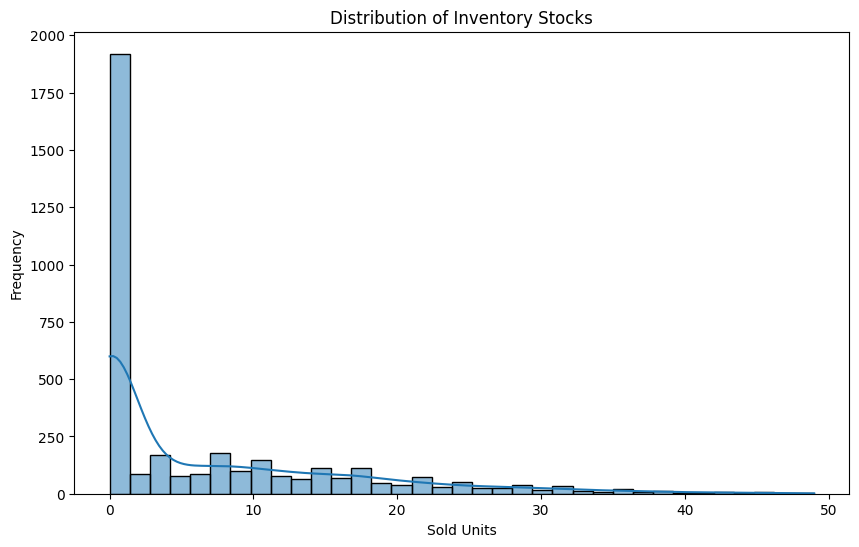

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(restaurant_data['Inventory Stock'], kde=True)
plt.title('Distribution of Inventory Stocks')
plt.xlabel('Sold Units')
plt.ylabel('Frequency')
plt.show()

In [108]:
# Initialize stock units and stock space
initial_stock_units = 100  # Starting stock units
stock_space = []
df = restaurant_data.copy()
df.drop(columns=["Stock Units","Profit"], inplace=True)
# Function to sample from stock_space
def sample_stock_space(stock_space):
    if stock_space:
        return np.random.choice(stock_space)
    return 0

df['Stock Units'] = initial_stock_units
for i in range(1, len(df)):
    today_stock_units = df.at[i-1, 'Stock Units']
    today_sold_units = restaurant_data.at[i-1, 'Sold Units']
    abs_diff = abs(today_stock_units - today_sold_units)
    
    # Update stock_space
    stock_space.append(abs_diff)
    
    # Calculate next day's stock units
    if today_stock_units <= today_sold_units:
        next_stock_units = today_stock_units + sample_stock_space(stock_space)
    elif today_stock_units > today_sold_units:
        next_stock_units = today_stock_units - sample_stock_space(stock_space)
    # else:
    #     next_stock_units = today_sold_units
    
    df.at[i, 'Stock Units'] = next_stock_units

# Display the DataFrame
df["Profit"] = np.where(
    df["Sold Units"] <= df["Stock Units"],
    df["Sold Units"] * 3 - df["Stock Units"] * 1,
    df["Stock Units"] * 3 - df["Stock Units"] * 1
)

total_profit = df['Profit'].sum()
print('Total Profit:', total_profit)

Total Profit: 717548


In [76]:
total_profit = df['Profit'].sum()
print('Total Profit:', total_profit)

Total Profit: 748844


Ok it's not good, try a new scenario

In [22]:
import pandas as pd
import numpy as np

df = restaurant_data.copy()
df.drop(columns=["Stock Units","Profit"], inplace=True)

# Initialize stock units and stock space
initial_stock_units = 100  # Starting stock units
stock_space = []

# Function to sample from stock_space
def sample_stock_space(stock_space):
    if stock_space:
        return np.random.choice(stock_space)
    return 0

# Adjust stock units based on the described logic
df['Stock Units'] = initial_stock_units
for i in range(1, len(df)):
    today_sold_units = df.at[i, 'Sold Units']
    yesterday_sold_units = df.at[i-1, 'Sold Units']
    abs_diff = abs(today_sold_units - yesterday_sold_units)
    
    # Update stock_space
    stock_space.append(abs_diff)
    
    today_stock_units = df.at[i-1, 'Stock Units']
    
    # Calculate next day's stock units
    if today_stock_units == today_sold_units:
        next_stock_units = today_stock_units + sample_stock_space(stock_space)
    elif today_stock_units > today_sold_units:
        next_stock_units = today_stock_units - sample_stock_space(stock_space)
    else:
        next_stock_units = today_sold_units
    
    df.at[i, 'Stock Units'] = next_stock_units

# Display the DataFrame
df

,Sold Units,Stock Change,Missed Demand,Date,Inventory Stock,Stock Units
0,100,5,Yes,2010-01-01,0,100
1,105,4,Yes,2010-01-02,0,105
2,109,3,Yes,2010-01-03,0,109
3,85,-5,No,2010-01-04,27,105
4,107,3,Yes,2010-01-05,0,107
...,...,...,...,...,...,...
3645,114,5,Yes,2019-12-25,0,114
3646,116,-5,No,2019-12-26,3,116
3647,97,-4,No,2019-12-27,17,116
3648,83,-4,No,2019-12-28,27,113


In [23]:
df["Profit"] = np.where(
    df["Sold Units"] <= df["Stock Units"],
    df["Sold Units"] * 3 - df["Stock Units"] * 1,
    df["Stock Units"] * 3 - df["Stock Units"] * 1
)
total_profit = df['Profit'].sum()
print('Total Profit:', total_profit)

Total Profit: 771152


Ok, now try with new way

In [24]:
df = restaurant_data.copy()
df.drop(columns=["Stock Units","Profit"], inplace=True)

# Initialize stock units
df['Stock Units'] = 100  # Starting stock units

# Loop to calculate the average of sold units by day and assign it as the stock units
for i in range(1, len(df)):
    average_sold_units = np.ceil(df['Sold Units'][:i].mean()).astype(int)
    df.at[i, 'Stock Units'] = average_sold_units

# Display the DataFrame
df

,Sold Units,Stock Change,Missed Demand,Date,Inventory Stock,Stock Units
0,100,5,Yes,2010-01-01,0,100
1,105,4,Yes,2010-01-02,0,100
2,109,3,Yes,2010-01-03,0,103
3,85,-5,No,2010-01-04,27,105
4,107,3,Yes,2010-01-05,0,100
...,...,...,...,...,...,...
3645,114,5,Yes,2019-12-25,0,109
3646,116,-5,No,2019-12-26,3,109
3647,97,-4,No,2019-12-27,17,109
3648,83,-4,No,2019-12-28,27,109


In [25]:
df["Profit"] = np.where(
    df["Sold Units"] <= df["Stock Units"],
    df["Sold Units"] * 3 - df["Stock Units"] * 1,
    df["Stock Units"] * 3 - df["Stock Units"] * 1
)
total_profit = df['Profit'].sum()
print('Total Profit:', total_profit)

Total Profit: 754956


Lol bad af, try new way

In [26]:
df = restaurant_data.copy()
df.drop(columns=["Stock Units","Profit"], inplace=True)

# Initialize stock units
df['Stock Units'] = 100  # Starting stock units

# Loop to calculate the average of sold units by day and assign it as the stock units
for i in range(1, len(df)):
    average_sold_units = np.ceil(df['Stock Units'][:i].mean()).astype(int)
    df.at[i, 'Stock Units'] = average_sold_units

# Display the DataFrame
df["Profit"] = np.where(
    df["Sold Units"] <= df["Stock Units"],
    df["Sold Units"] * 3 - df["Stock Units"] * 1,
    df["Stock Units"] * 3 - df["Stock Units"] * 1
)
total_profit = df['Profit'].sum()
print('Total Profit:', total_profit)

Total Profit: 717037


In [27]:
df = restaurant_data.copy()
df.drop(columns=["Stock Units","Profit"], inplace=True)
df['Stock Units'] = np.ceil(df['Sold Units'].expanding().mean())
df["Profit"] = np.where(
    df["Sold Units"] <= df["Stock Units"],
    df["Sold Units"] * 3 - df["Stock Units"] * 1,
    df["Stock Units"] * 3 - df["Stock Units"] * 1
)
total_profit = df['Profit'].sum()
print('Total Profit:', total_profit)

Total Profit: 755076.0


In [34]:
restaurant_data

,Stock Units,Sold Units,Stock Change,Missed Demand,Profit
Date,,,,,
2010-01-01,100,100,5,Yes,200
2010-01-02,105,105,4,Yes,210
2010-01-03,109,109,3,Yes,218
2010-01-04,112,85,-5,No,143
2010-01-05,107,107,3,Yes,214
...,...,...,...,...,...
2019-12-25,114,114,5,Yes,228
2019-12-26,119,116,-5,No,229
2019-12-27,114,97,-4,No,177


In [36]:
df = restaurant_data.copy()
df.drop(columns=["Stock Units","Profit"], inplace=True)

# Set 'Date' as the index
df.set_index("Date", inplace=True)

# Decompose the time series
result = seasonal_decompose(df['Sold Units'], model='additive', period=365)

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

KeyError: "None of ['Date'] are in the columns"

In [29]:
restaurant_data_scenarios = restaurant_data.copy()

In [30]:
restaurant_data_scenarios['Stock Units Approx'] = restaurant_data_scenarios['Sold Units'].shift(1).fillna(restaurant_data_scenarios['Sold Units'].iloc[0]).astype(int)
restaurant_data_scenarios

,Stock Units,Sold Units,Stock Change,Missed Demand,Profit,Date,Inventory Stock,Stock Units Approx
0,100,100,5,Yes,200,2010-01-01,0,100
1,105,105,4,Yes,210,2010-01-02,0,100
2,109,109,3,Yes,218,2010-01-03,0,105
3,112,85,-5,No,143,2010-01-04,27,109
4,107,107,3,Yes,214,2010-01-05,0,85
...,...,...,...,...,...,...,...,...
3645,114,114,5,Yes,228,2019-12-25,0,110
3646,119,116,-5,No,229,2019-12-26,3,114
3647,114,97,-4,No,177,2019-12-27,17,116
3648,110,83,-4,No,139,2019-12-28,27,97


In [31]:
restaurant_data_scenarios["Profit Approx"] = np.where(
    restaurant_data_scenarios["Sold Units"] <= restaurant_data_scenarios["Stock Units Approx"],
    restaurant_data_scenarios["Sold Units"] * 3 - restaurant_data_scenarios["Stock Units Approx"] * 1,
    restaurant_data_scenarios["Stock Units Approx"] * 3 - restaurant_data_scenarios["Stock Units Approx"] * 1
)
restaurant_data_scenarios

,Stock Units,Sold Units,Stock Change,Missed Demand,Profit,Date,Inventory Stock,Stock Units Approx,Profit Approx
0,100,100,5,Yes,200,2010-01-01,0,100,200
1,105,105,4,Yes,210,2010-01-02,0,100,200
2,109,109,3,Yes,218,2010-01-03,0,105,210
3,112,85,-5,No,143,2010-01-04,27,109,146
4,107,107,3,Yes,214,2010-01-05,0,85,170
...,...,...,...,...,...,...,...,...,...
3645,114,114,5,Yes,228,2019-12-25,0,110,220
3646,119,116,-5,No,229,2019-12-26,3,114,228
3647,114,97,-4,No,177,2019-12-27,17,116,175
3648,110,83,-4,No,139,2019-12-28,27,97,152


In [32]:
restaurant_data_scenarios['Missed Demand Approx'] = np.where(restaurant_data_scenarios['Stock Units Approx'] >= restaurant_data_scenarios['Sold Units'], 'Yes', 'No')
restaurant_data_scenarios

,Stock Units,Sold Units,Stock Change,Missed Demand,Profit,Date,Inventory Stock,Stock Units Approx,Profit Approx,Missed Demand Approx
0,100,100,5,Yes,200,2010-01-01,0,100,200,Yes
1,105,105,4,Yes,210,2010-01-02,0,100,200,No
2,109,109,3,Yes,218,2010-01-03,0,105,210,No
3,112,85,-5,No,143,2010-01-04,27,109,146,Yes
4,107,107,3,Yes,214,2010-01-05,0,85,170,No
...,...,...,...,...,...,...,...,...,...,...
3645,114,114,5,Yes,228,2019-12-25,0,110,220,No
3646,119,116,-5,No,229,2019-12-26,3,114,228,No
3647,114,97,-4,No,177,2019-12-27,17,116,175,Yes
3648,110,83,-4,No,139,2019-12-28,27,97,152,Yes


In [33]:
# Calculate the percentage of missed demand approx
missed_demand_approx_percentage = (restaurant_data_scenarios['Missed Demand Approx'] == 'Yes').mean() * 100
print('Missed Demand Approx Percentage:', missed_demand_approx_percentage)

# Calculate the total profit approx and compare it with the original profit
total_profit_approx = restaurant_data_scenarios['Profit Approx'].sum()
total_profit = restaurant_data_scenarios['Profit'].sum()
profit_difference = total_profit_approx - total_profit
profit_percentage_increase = (profit_difference / total_profit) * 100

print('Total Profit Approx:', total_profit_approx)
print('Total Profit:', total_profit)
print('Profit Difference:', profit_difference)
print('Profit Percentage Increase:', profit_percentage_increase)

Missed Demand Approx Percentage: 43.397260273972606
Total Profit Approx: 746185
Total Profit: 769702
Profit Difference: -23517
Profit Percentage Increase: -3.0553382997575684


# Question 2

- What is the product that is the most for attracting new users when talking about advertisement cost. 

- What is the product that is the most for optimizing revenue (revenue growth while using least advertising fee).

- What is the product that is the most effective for optimizing profit per advertising fee

## Question 2.1

In [18]:
price = {
    'Product': ['A', 'B', 'C'],
    'Price': [5, 12, 7]
}
price_df = pd.DataFrame(price)

result = {
    'Product': ['A', 'B', 'C'],
    'Sold Units M1': [1000, 300, 600],
    'Sold Units M2': [90, 50, 66],
    'Sold Units M3': [72, 45, 58]
}
result_df = pd.DataFrame(result)

marketing_cost = {
    'Product': ['A', 'B', 'C'],
    'Marketing Cost': [1650, 1250, 1400]
}
marketing_cost_df = pd.DataFrame(marketing_cost)

cost_per_product_sold = {
    'Product': ['A', 'B', 'C'],
    'Platform Fee': [0.15, 0.15, 0.15],
    'Sale Tax': [0.08, 0.08, 0.08],
    'COGs': [0.35, 0.33, 0.40],
    'Fulfillment Fee': [0.03, 0.03, 0.03],
    'New Customer Discount': [0.12, 0.12, 0.12],
    'Return Customer Discount': [0.10, 0.10, 0.10]
}

cost_per_product_sold_df = pd.DataFrame(cost_per_product_sold)

In order to answer the question: which product helps attract new users most cost effectively in terms of ads, we need to analyze several key metrics to determine which product delivers the best results when it comes to cost-effective advertising for invite more using. I will use 2 main metrics for calculating this:

1. Customer Acquisition Cost (CAC): CAC measures how much it costs to acquire a new user through advertising efforts. It's calculated by dividing the total ad spend by the number of new users acquired. A lower CAC indicates more cost-effective user acquisition.

2. Return on Ad Spend (ROAS): ROAS shows how much revenue is generated for every dollar spent on ads. It’s essential for determining which product delivers the best financial returns on ad investments. A higher ROAS indicates better performance.

In [19]:
# Step 1: Calculate Total Revenue per Product from New Customers (Month 1 Sales)
price_df['Sold Units M1'] = result_df['Sold Units M1']
price_df['Revenue M1'] = price_df['Price'] * price_df['Sold Units M1']
price_df['Revenue M2'] = price_df['Price'] * result_df['Sold Units M2']
price_df['Revenue M3'] = price_df['Price'] * result_df['Sold Units M3']

# Step 2: Calculate Total Cost per Unit Sold
cost_per_product_sold_df['Total Cost per Unit Sold'] = (
    cost_per_product_sold_df['Platform Fee'] +
    cost_per_product_sold_df['Sale Tax'] +
    cost_per_product_sold_df['COGs'] +
    cost_per_product_sold_df['Fulfillment Fee'] +
    cost_per_product_sold_df['New Customer Discount']
)

# Merge price and cost_per_product_sold data to calculate Total Cost (M1)
merged_cost_df = pd.merge(price_df, cost_per_product_sold_df, on='Product')

# Calculate Total Cost for Units Sold (M1)
merged_cost_df['Total Cost per Unit Sold (M1)'] = merged_cost_df['Price'] * merged_cost_df['Total Cost per Unit Sold']
merged_cost_df['Total Cost (M1)'] = merged_cost_df['Total Cost per Unit Sold (M1)'] * merged_cost_df['Sold Units M1']

# Step 3: Calculate Marketing Cost per New Customer (CAC)
merged_cost_df = pd.merge(merged_cost_df, marketing_cost_df, on='Product')
merged_cost_df['CAC'] = merged_cost_df['Marketing Cost'] / merged_cost_df['Sold Units M1']

# Step 4: Calculate ROAS
merged_cost_df['ROAS'] = merged_cost_df['Revenue M1'] / merged_cost_df['Marketing Cost']

# Include sold units for each month
merged_cost_df['Sold Units M1'] = result_df['Sold Units M1']
merged_cost_df['Sold Units M2'] = result_df['Sold Units M2']
merged_cost_df['Sold Units M3'] = result_df['Sold Units M3']

# Add marketing cost to the merged dataframe
merged_cost_df['Marketing Cost'] = marketing_cost_df['Marketing Cost']

merged_cost_df


,Product,Price,Sold Units M1,Revenue M1,Revenue M2,Revenue M3,Platform Fee,Sale Tax,COGs,Fulfillment Fee,New Customer Discount,Return Customer Discount,Total Cost per Unit Sold,Total Cost per Unit Sold (M1),Total Cost (M1),Marketing Cost,CAC,ROAS,Sold Units M2,Sold Units M3
0,A,5,1000,5000,450,360,0.15,0.08,0.35,0.03,0.12,0.1,0.73,3.65,3650.0,1650,1.650000,3.030303,90,72
1,B,12,300,3600,600,540,0.15,0.08,0.33,0.03,0.12,0.1,0.71,8.52,2556.0,1250,4.166667,2.880000,50,45
2,C,7,600,4200,462,406,0.15,0.08,0.40,0.03,0.12,0.1,0.78,5.46,3276.0,1400,2.333333,3.000000,66,58


In [20]:
merged_cost_df[['Product','Sold Units M1', 'Marketing Cost', 'CAC']]

,Product,Sold Units M1,Marketing Cost,CAC
0,A,1000,1650,1.650000
1,B,300,1250,4.166667
2,C,600,1400,2.333333


**Product A** is the most effective product for attracting new users when considering marketing ads because it has both the lowest cost to acquire a user (CAC) and the highest return on investment (ROAS). This combination makes it the best performer overall in terms of marketing efficiency.

## Question 2.2

In [21]:
# Step 1: Calculate Total Revenue for M1, M2, and M3 for each product
# Using price_df for revenue in M1 and result_df for units sold in M2, M3

price_df['Revenue M2'] = price_df['Price'] * result_df['Sold Units M2']
price_df['Revenue M3'] = price_df['Price'] * result_df['Sold Units M3']
price_df['Total Revenue (M1 + M2 + M3)'] = price_df['Revenue M1'] + price_df['Revenue M2'] + price_df['Revenue M3']

# Step 2: Calculate Revenue Growth Rate
price_df['Revenue Growth Rate'] = ((price_df['Revenue M3'] - price_df['Revenue M1']) / price_df['Revenue M1']) * 100

# Step 3: Calculate Ad Spend to Revenue Ratio (ASRR)
price_df = pd.merge(price_df, marketing_cost_df, on='Product')
price_df['ROAS'] = price_df['Total Revenue (M1 + M2 + M3)']/price_df['Marketing Cost']

# Step 4: Calculate Return Customer Rate
price_df['Return Customer Rate'] = ((result_df['Sold Units M2'] + result_df['Sold Units M3']) / result_df['Sold Units M1']) * 100

# Step 5: Calculate Cost per Incremental Revenue (CIR)
price_df['Total Cost (M2)'] = price_df['Price'] * cost_per_product_sold_df['Total Cost per Unit Sold'] * result_df['Sold Units M2']
price_df['Total Cost (M3)'] = price_df['Price'] * cost_per_product_sold_df['Total Cost per Unit Sold'] * result_df['Sold Units M3']
price_df['Total Cost (M1 + M2 + M3)'] = merged_cost_df['Total Cost (M1)'] + price_df['Total Cost (M2)'] + price_df['Total Cost (M3)']
price_df['CIR'] = price_df['Marketing Cost'] / (price_df['Total Revenue (M1 + M2 + M3)'] - price_df['Total Cost (M1 + M2 + M3)'])

# Step 6: LTV to CAC Ratio (Assuming LTV = Total Revenue from M1, M2, M3 for now)
price_df['LTV to CAC Ratio'] = price_df['Total Revenue (M1 + M2 + M3)'] / merged_cost_df['CAC']

price_df.drop(columns=["Revenue Growth Rate"], inplace=True)


In [22]:
price_df[["Product","Marketing Cost","ROAS","Return Customer Rate"]]

,Product,Marketing Cost,ROAS,Return Customer Rate
0,A,1650,3.521212,16.200000
1,B,1250,3.792000,31.666667
2,C,1400,3.620000,20.666667


- **Product B** seems to be the most efficient at optimizing sales growth with the least ad cost, given its higher return customer rate, lowest ASRR, and lowest CIR. It maintains revenue better post-advertising and spends the least per additional dollar of revenue growth.
However, Product A is the most profitable in terms of the lifetime value of customers acquired relative to its CAC, though it experienced a more significant sales decline in the later months.

## Question 2.3

In [25]:
# Step 1: Calculate Profit per Ad Spend (PAS)
price_df['PAS'] = (price_df['Total Revenue (M1 + M2 + M3)'] - price_df['Total Cost (M1 + M2 + M3)']) / price_df['Marketing Cost']

# Rename columns
price_df.rename(columns={
    'Total Revenue (M1 + M2 + M3)': 'Total Revenue',
    'Total Cost (M1 + M2 + M3)': 'Total Cost'
}, inplace=True)

# Display the updated dataframe with PAS
price_df[["Product", "Marketing Cost", "ROAS", "PAS", "Total Revenue", "Total Cost"]]

,Product,Marketing Cost,ROAS,PAS,Total Revenue,Total Cost
0,A,1650,3.521212,0.950727,5810,4241.30
1,B,1250,3.792000,1.099680,4740,3365.40
2,C,1400,3.620000,0.796400,5068,3953.04
